.

# Исследование надежности заемщиков.

# **Описание проекта**


Заказчик — кредитный отдел банка. Нужно разобраться:

* влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. 

Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели кредитного скоринга — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку

Будем смотреть влияние детей / семейного статуса / категории кредита  на возврат кредита в срок


### Шаг 1. Обзор данных

Описание данных

children — количество детей в семье

days_employed — общий трудовой стаж в днях

dob_years — возраст клиента в годах

education — уровень образования клиента

education_id — идентификатор уровня образования

family_status — семейное положение

family_status_id — идентификатор семейного положения

gender — пол клиента

income_type — тип занятости

debt — имел ли задолженность по возврату кредитов

total_income — ежемесячный доход

purpose — цель получения кредита

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# сохраним старый датасет на всякий случай
df = pd.read_csv('data.csv')
df_ = df.copy()
df.head(5)
# уже видим какие то странные отрицательные значения, обработаем из позже

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


### Шаг 2.1 Заполнение пропусков

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Видим, что в столбцах days_employed, total_income есть пропуски.

Пропуски в числовых данных - возможная ошибка человека, обычно их заполняют медианным значением или средним, но сперва нужно проверить данные на выбросы

Оценим долю пропусков в каждом столбце:

In [4]:
print('Для  days_employed ',  df.days_employed.isna().sum() / len(df))
print('Для  total_income ', df.total_income.isna().sum() / len(df))

Для  days_employed  0.10099883855981417
Для  total_income  0.10099883855981417


В столбце total_income проверим данные на выбросы

<AxesSubplot:>

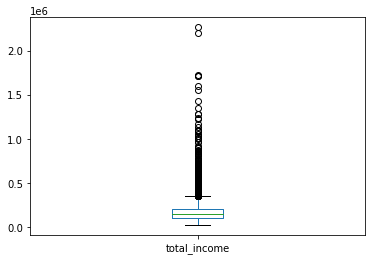

In [5]:
df['total_income'].plot(kind = 'box')

Видим что есть выбросы, заменяем медианным значением - тк медиана меньше всего подвержена выбросам

In [6]:
df['total_income'] = df['total_income'].fillna(df['total_income'].median())

### Шаг 2.2 Проверка данных на аномалии и исправления.

В столбце days_employed отрицательное количество дней трудового стажа. Число отрицательных значений намного больше чем положительных, скорее всего минус поставили случайно, поэтому отбросим его

In [7]:
print('Отрицательных', df[df['days_employed'] < 0]['children'].count())
print('Положительных', df[df['days_employed'] > 0]['children'].count())

Отрицательных 15906
Положительных 3445


In [8]:
# теперь будут только положительные
df['days_employed'] = df['days_employed'].apply(abs)

Мы избаились о отрицательных значений, но у нас все еще могут быть очень большие положительные значения.

Посмтрим на распределение и решим как заполнить пропуски

<AxesSubplot:>

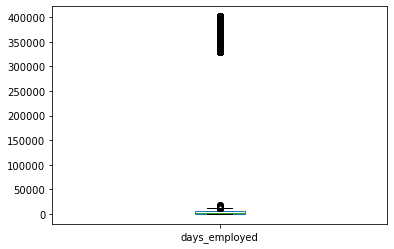

In [9]:
df['days_employed'].plot(kind = 'box')

*видим что есть выбросы, исследуем*


In [10]:
# смотрим долю выбросов
print('Доля выбросов:', len(df.query('days_employed > 300000') ) / len(df))
# 

Доля выбросов: 0.16004645760743322


Доля выбросов не очень большая, удалим их, посмотрим распределение основной массы

<AxesSubplot:>

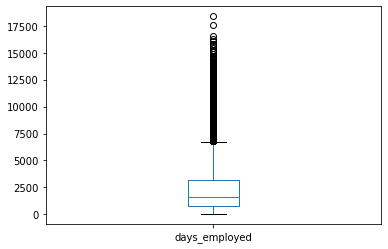

In [11]:
df = df.query('days_employed < 300000')
df['days_employed'].plot(kind = 'box')

In [12]:
# теперь можно заполнить пропуски медианой
df['days_employed'] = df['days_employed'].fillna(df['days_employed'].mean())
# проверим на пропуски ещё раз
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15906 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          15906 non-null  int64  
 1   days_employed     15906 non-null  float64
 2   dob_years         15906 non-null  int64  
 3   education         15906 non-null  object 
 4   education_id      15906 non-null  int64  
 5   family_status     15906 non-null  object 
 6   family_status_id  15906 non-null  int64  
 7   gender            15906 non-null  object 
 8   income_type       15906 non-null  object 
 9   debt              15906 non-null  int64  
 10  total_income      15906 non-null  float64
 11  purpose           15906 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 1.6+ MB


Проверим на аномалии остальные столбцы

In [13]:
df['children'].unique()
# -1 ребёнок очень странно

array([ 1,  0,  3,  2, -1,  4, 20,  5], dtype=int64)

In [14]:
# посмотрим на долю аномальных значений, если она меньше 5% то удалим их
print('20 детей ...', len(df.query('children == 20')) *100 / len(df))
print('-1 ребёнок ...', len(df.query('children == -1')) *100 / len(df))

20 детей ... 0.37721614485099964
-1 ребёнок ... 0.23261662265811645


In [15]:
df = df.query('children != 20')
df = df.query('children != -1')
# проверим на выбросы, всё хорошо
df['children'].unique()

array([1, 0, 3, 2, 4, 5], dtype=int64)

### Шаг 2.3. Изменение типов данных.

Заменим тип данныx с float64 на int64

In [16]:
df['total_income'] = (df['total_income'] // 1).astype('int64', errors='ignore')
df['total_income'].head()

0    253875
1    112080
2    145885
3    267628
5    255763
Name: total_income, dtype: int64

### Шаг 2.4. Удаление дубликатов.

возможные причины дубликатов - ошибка в хранении/перемещении данных

In [17]:
#Сколько явных дублей было до обработки (смотрим по старому датасету, который скопировали в самом начале) :
df_.duplicated().sum()

54

In [18]:
#посмотрим уникальные значения на дубликаты с помощью .unique()
print('было:', df['education'].unique())
#приведём их к одному регистру
print('стало после обработки:',df['education'].str.lower().unique())
df.loc[:, 'education'] = df.loc[:, 'education'].str.lower()

было: ['высшее' 'среднее' 'Среднее' 'СРЕДНЕЕ' 'ВЫСШЕЕ' 'неоконченное высшее'
 'начальное' 'Высшее' 'НЕОКОНЧЕННОЕ ВЫСШЕЕ' 'Неоконченное высшее'
 'НАЧАЛЬНОЕ' 'Начальное' 'УЧЕНАЯ СТЕПЕНЬ' 'ученая степень']
стало после обработки: ['высшее' 'среднее' 'неоконченное высшее' 'начальное' 'ученая степень']


In [19]:
# проверим уникальные значения других столбцов
print(df['family_status'].unique())
print(df['income_type'].unique())
print(df['purpose'].unique())
print(df['gender'].unique())

['женат / замужем' 'гражданский брак' 'в разводе' 'Не женат / не замужем'
 'вдовец / вдова']
['сотрудник' 'компаньон' 'госслужащий' 'студент' 'предприниматель'
 'в декрете']
['покупка жилья' 'приобретение автомобиля' 'дополнительное образование'
 'операции с жильем' 'образование' 'на проведение свадьбы'
 'покупка жилья для семьи' 'покупка недвижимости'
 'покупка коммерческой недвижимости' 'покупка жилой недвижимости'
 'строительство собственной недвижимости' 'недвижимость'
 'строительство недвижимости' 'на покупку своего автомобиля'
 'на покупку подержанного автомобиля' 'сыграть свадьбу' 'жилье'
 'операции со своей недвижимостью' 'автомобили' 'заняться образованием'
 'получение образования' 'сделка с подержанным автомобилем' 'автомобиль'
 'свадьба' 'получение дополнительного образования' 'покупка своего жилья'
 'операции с недвижимостью' 'получение высшего образования'
 'операции с коммерческой недвижимостью' 'свой автомобиль'
 'сделка с автомобилем' 'профильное образование' 'высшее об

В столбце 'gender' есть пропуски - XNA. Оказывается такая строка всего одна, удалим её

In [20]:
df[df['gender'] == 'XNA']

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
10701,0,2358.600502,24,неоконченное высшее,2,гражданский брак,1,XNA,компаньон,0,203905,покупка недвижимости


In [21]:
df = df[df.gender != 'XNA'].reset_index(drop = True)
df.head(3)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья
1,1,4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля
2,0,5623.422610,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья


In [22]:
# посмотрим есть ли явные дубликаты:
df.duplicated().sum()

0

Явных дубликатов не осталось, можем шагать дальше.

### Шаг 2.5. Формирование дополнительных датафреймов словарей, декомпозиция исходного датафрейма.

Уменьшим наш датафрейм, вынесем информацию об образовании и семейном статусе в отдельные таблицы

In [23]:
df_education = df[['education', 'education_id']]
df_education.head(15)

,education,education_id
0,высшее,0
1,среднее,1
2,среднее,1
3,среднее,1
4,высшее,0
5,высшее,0
6,среднее,1
7,высшее,0
8,среднее,1
9,высшее,0


In [24]:
df_family = df[['family_status', 'family_status_id']]
df_family.head(3)

,family_status,family_status_id
0,женат / замужем,0
1,женат / замужем,0
2,женат / замужем,0


In [25]:
df = df.drop(['education', 'family_status'], axis = 1)
df.head(3)

,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437.673028,42,0,0,F,сотрудник,0,253875,покупка жилья
1,1,4024.803754,36,1,0,F,сотрудник,0,112080,приобретение автомобиля
2,0,5623.422610,33,1,0,M,сотрудник,0,145885,покупка жилья


### Шаг 2.6. Категоризация дохода.

Создадим функцию и потом применим её к столбцу чтобы закодировать переменные

In [26]:
def type_category(number):
    if number <= 30000:
        return 'E'
    elif 30001 <= number  <= 50000:
        return 'D'
    elif 50001 <= number  <= 200000:
        return 'C' 
    elif 200001 <= number  <= 1000000:
        return 'B'
    elif number >= 1000001:
        return 'A'

In [27]:
df['total_income_category'] = df['total_income'].apply(type_category)

In [28]:
# теперь можно отщепить total_income от исходной таблицы
df_income_type = df[['total_income', 'total_income_category']]
df = df.drop('total_income', axis = 1)


### Шаг 2.7. Категоризация целей кредита.

In [29]:
# посмотрим на уникальные значения
df['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'операции с жильем', 'образование',
       'на проведение свадьбы', 'покупка жилья для семьи',
       'покупка недвижимости', 'покупка коммерческой недвижимости',
       'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку своего автомобиля',
       'на покупку подержанного автомобиля', 'сыграть свадьбу', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'получение образования',
       'сделка с подержанным автомобилем', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'операции с коммерческой недвижимостью', 'свой автомобиль',
       'сделка с автомобилем', 'профильное образование',
       'высшее образование', 'на покупку автомобиля',
      

In [30]:
def purpose_cod(purpose):
    if 'авто' in purpose:
        return 'операции с автомобилем'
    elif 'образов' in purpose:
        return 'получение образования'
    elif ('недвиж' in purpose) or ('жиль' in purpose):
        return 'операции с недвижимостью'
    elif 'свадьб' in purpose:
        return 'проведение свадьбы'

In [31]:
df['purpose_category'] = df['purpose'].apply(purpose_cod)

In [32]:
df_purpose = df[['purpose', 'purpose_category']]
# выкинем столбец purpose тк же закодировали его в purpose_category, при этом сохранив подвыборку с исходной таблицы
df = df.drop('purpose', axis = 1)

In [33]:
#посмтрим что у нас вышло
df.head(4)

,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income_category,purpose_category
0,1,8437.673028,42,0,0,F,сотрудник,0,B,операции с недвижимостью
1,1,4024.803754,36,1,0,F,сотрудник,0,C,операции с автомобилем
2,0,5623.422610,33,1,0,M,сотрудник,0,C,операции с недвижимостью
3,3,4124.747207,32,1,0,M,сотрудник,0,B,получение образования


### Ответы на вопросы.

##### Вопрос 1:   Есть ли зависимость между количеством детей и возвратом кредита в срок?

Посчитаем среднее количество детей у тех, кто возвращал кредит , и у тех у кого есть зодолженность. 

построим график 

In [34]:
has_debt = df.loc[df['debt'] == 1, 'children'].mean()
no_debt = df.loc[df['debt'] == 0, 'children'].mean()

In [35]:
print('среднее по детям у задолженников : ', has_debt)
print('среднее по детям у не-задолженников : ', no_debt)

среднее по детям у задолженников :  0.5949275362318841
среднее по детям у не-задолженников :  0.552606043803715


<AxesSubplot:xlabel='children', ylabel='debt'>

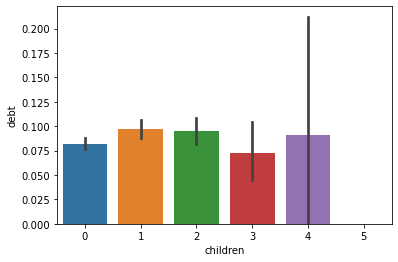

In [36]:
sns.barplot(data=df, x="children", y="debt" )

Видно, что среднее у одних и у других примерно одинаковое.


На графике сильных различий по высоте столбцов тоже нет 

посмотрим на сводную таблицу

In [37]:
 df.pivot_table(index=['children'], values='debt', aggfunc=['sum','count','mean'])

,sum,count,mean
,debt,debt,debt
children,,,
0,785,9555,0.082156
1,396,4090,0.096822
2,175,1834,0.095420
3,21,288,0.072917
4,3,33,0.090909
5,0,8,0.000000


Видно что среди тех, у кого нет детей доля должников = 0,08

А среди родителей (только если у тебя не 3 или 5 детей) = 0,09

Различия слабые, но всё же, можем сказать, что семьи с детьми хуже отдают кредиты

##### Вопрос 2:  Есть ли зависимость между семейным положением и возвратом кредита в срок?

Сгруппируем таблицу по столбцу debt (имел ли задолженность по возврату кредитов), и посчитаем сколько каждой категории статуса семьи 

In [38]:
family_status_debt = df.groupby('debt')['family_status_id'].value_counts().reset_index(name='count')
family_status_debt

,debt,family_status_id,count
0,0,0,8459
1,0,1,2835
2,0,4,1963
3,0,3,817
4,0,2,354
5,1,0,744
6,1,1,307
7,1,4,241
8,1,3,64
9,1,2,24


In [39]:
# выведем это через сводную таблицу, для наглядности
family_debt_piv = pd.pivot_table(family_status_debt, index = 'family_status_id', columns = 'debt', values = 'count')

family_debt_piv

debt,0,1
family_status_id,,
0,8459,744
1,2835,307
2,354,24
3,817,64
4,1963,241


Можем построить график для каждой группы семейного положения, перед этим найдем количество людей в каждой группе и посмотрим на долю должников

In [40]:
family_debt_piv_  = family_debt_piv.reset_index()
family_debt_piv_['sum'] = family_debt_piv_[0] + family_debt_piv_[1]
family_debt_piv_

debt,family_status_id,0,1,sum
0,0,8459,744,9203
1,1,2835,307,3142
2,2,354,24,378
3,3,817,64,881
4,4,1963,241,2204


Text(0.5, 1.0, 'Доля должников в каждом статусе')

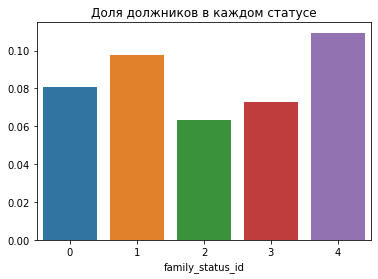

In [41]:
sns.barplot(x = family_debt_piv_.family_status_id, y = family_debt_piv_[1] / family_debt_piv_['sum'])
plt.title('Доля должников в каждом статусе')

In [42]:
# вспомним расшифровку цифра - значение для семейного статуса:
df_family.groupby('family_status').first()

,family_status_id
family_status,
Не женат / не замужем,4
в разводе,3
вдовец / вдова,2
гражданский брак,1
женат / замужем,0


 **Видим, что не женатые или в гражданском браке чаще склонны не отдавать кредиты**

##### Вопрос 3:  Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

Проделаем то же самое что и для категорий семейного статуса

In [43]:
income_debt = df.groupby('debt')['total_income_category'].value_counts().reset_index(name='count')
income_debt_pivot = pd.pivot_table(data = income_debt, columns= 'debt', index = 'total_income_category', values = 'count')
income_debt_pivot

debt,0,1
total_income_category,,
A,23.0,2.0
B,4136.0,323.0
C,10091.0,1041.0
D,171.0,14.0
E,7.0,NaN


Смотрим откуда выполз NaN

In [44]:
df.query('total_income_category == "E"')
# оказывается с категорией E debt = 0 везде

,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income_category,purpose_category
6075,0,615.774147,46,1,0,F,сотрудник,0,E,операции с недвижимостью
7420,0,4959.893007,43,1,0,F,сотрудник,0,E,получение образования
10972,2,1440.353367,28,1,1,F,сотрудник,0,E,проведение свадьбы
11316,1,2945.051315,45,1,0,F,сотрудник,0,E,операции с недвижимостью
11898,1,3642.820023,52,1,0,M,сотрудник,0,E,операции с автомобилем
12199,0,241.247456,49,1,1,F,компаньон,0,E,проведение свадьбы
13718,1,1953.777603,50,1,0,F,госслужащий,0,E,операции с автомобилем


In [45]:
# заменим его на 0
income_debt_pivot[1][4] = 0
income_debt_pivot = income_debt_pivot.reset_index()
income_debt_pivot['sum'] = income_debt_pivot[0] + income_debt_pivot[1]
income_debt_pivot

debt,total_income_category,0,1,sum
0,A,23.0,2.0,25.0
1,B,4136.0,323.0,4459.0
2,C,10091.0,1041.0,11132.0
3,D,171.0,14.0,185.0
4,E,7.0,0.0,7.0


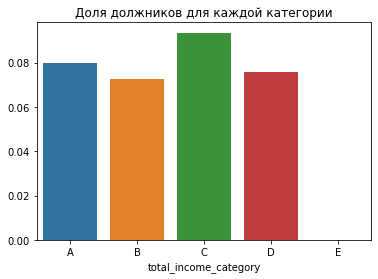

In [46]:
# график для тех кто не имеет задолженностей
sns.barplot( x = income_debt_pivot['total_income_category'], y = income_debt_pivot[1] / income_debt_pivot['sum'])
plt.title('Доля должников для каждой категории')
print()

Помним что мы создавали категории:

0–30000 — 'E';

30001–50000 — 'D';

50001–200000 — 'C';

200001–1000000 — 'B';

1000001 и выше — 'A'.

Среди категории С - наибольшая доля должников

##### Вопрос 4:  Как разные цели кредита влияют на его возврат в срок?

In [47]:
purpose_debt = df.groupby('debt')['purpose_category'].value_counts().reset_index( name='count')
purpose_debt_pivot = pd.pivot_table(data = purpose_debt, columns= 'debt', index = 'purpose_category', values = 'count')
purpose_debt_pivot['rate'] = purpose_debt_pivot[1] / (purpose_debt_pivot[1] + purpose_debt_pivot[0]) 
purpose_debt_pivot = purpose_debt_pivot.reset_index()

In [48]:
purpose_debt_pivot

debt,purpose_category,0,1,rate
0,операции с автомобилем,2839,321,0.101582
1,операции с недвижимостью,7375,635,0.079276
2,получение образования,2635,288,0.098529
3,проведение свадьбы,1579,136,0.079300


<AxesSubplot:xlabel='purpose_category', ylabel='rate'>

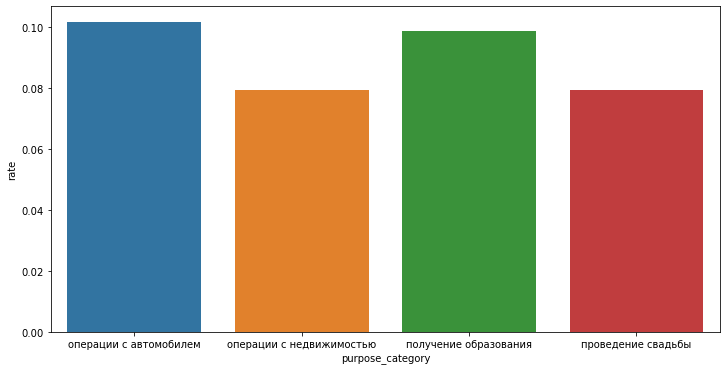

In [49]:
plt.figure(figsize = (12, 6))
sns.barplot(x = purpose_debt_pivot['purpose_category'], y = purpose_debt_pivot['rate'])

**Видим, что люди хуже отдают кредеиты, связанные с автомабилем и образованием**

## Общий вывод:

1. Обнаружили что у нас есть пропуски. Перед их заполнением проверили данные на выбросы и аномальные значения, исправили их, и затем заполнили пропуски
2. Обработали дубликаты
3. Закодировали переменные, сохраним словари в отдельные переменные
4. Посмотрели на распределения данных, чтобы выявить зависимости и получили :



* можем сказать, что семьи с детьми хуже отдают кредиты
* Видим, что не женатые или в гражданском браке чаще склонны не отдавать кредиты
* Среди категории С (средний уровень дохода) - наибольшая доля должников
* Видим, что люди хуже отдают кредеиты, связанные с автомабилем и образованием